In [3]:
import pickle
import tensorflow as tf
import numpy as np
import pprint as pp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed, GRU
from keras.callbacks import TensorBoard
from keras import backend as K
from time import time 

# Misc. Functions

In [4]:
def load_in(path):
    return pickle.load(open(path,'rb'))
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot ) )
def save_model(model):
    model.save('../my_model.h5')

# Load in Data

In [5]:
filename = '../data/player_data/lebron_2018.pkl'
player = load_in(filename)
X_justloaded = player['X'][:-1]
y_justloaded = player['y'][:-1]

# Reshape Data

We are interested in exploring if the $t$-th fantasy point has dependency on the previous $l$ inputs - this will be `lookback` in code. 

LTSM and other recurrent layers, in Keras, expect a tensor in the form given by the tuple:$$(samples, timesteps, features)$$
* **samples** - number of sequences of length "time steps".
* **timesteps** - how many steps including and behind the current is important, i.e. $l + 1$ steps.
* **features** - number of feautures.

Say the number of observations in the array `X` is $76$. If we consider that the last 5 ( i.e. `lookback = 5`) to be of particular importance, then we can cosntruct inputs to reflect that. The following function will build up exactly $76 - l$ samples with $l+1$ timesteps with same number of features as `X`

In [6]:
def make_overlapped_inputs(X,y,lookback = 1,):
    out = np.zeros((X.shape[0]-lookback,lookback+1,X.shape[1]))
    for i in range(lookback,X.shape[0]):
        out[i-lookback,:,:] = X[(i-lookback):i+1,:]
    y_out = y[lookback::]
    return out,y_out

In [7]:
lookback = 5
X,y = make_overlapped_inputs(X_justloaded,y_justloaded,lookback)
print(y.shape,X.shape)

(71,) (71, 6, 95)


# Model Definiton + Compilation

In [10]:

model = Sequential()
model.add(GRU(1,input_shape = (lookback+1,95), unroll=False, return_sequences=True))
model.add(GRU(10, input_shape=(10,), return_sequences=False))
model.add((Dense(1)))
model.add(Activation("linear"))

# Choose the loss and optimisation scheme.
model.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mae','mse','accuracy',coeff_determination])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 6, 1)              291       
_________________________________________________________________
gru_6 (GRU)                  (None, 10)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 662
Trainable params: 662
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_ratio = 0.5

train_n = int(len(y)*train_ratio)

X_train = X[:train_n]
y_train = y[:train_n]
X_test = X[train_n:]
y_test = y[train_n:]

model.fit(X_train, y_train, epochs=10000, batch_size=50, validation_data= (X_test, y_test))

Train on 35 samples, validate on 36 samples
Epoch 1/10000
35/35 [==============================] - 0s 1ms/step - loss: 156.3124 - mean_absolute_error: 10.5934 - mean_squared_error: 156.3124 - acc: 0.0000e+00 - coeff_determination: -0.0348 - val_loss: 146.3638 - val_mean_absolute_error: 9.8827 - val_mean_squared_error: 146.3638 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2590
Epoch 2/10000
35/35 [==============================] - 0s 741us/step - loss: 156.2996 - mean_absolute_error: 10.5924 - mean_squared_error: 156.2996 - acc: 0.0000e+00 - coeff_determination: -0.0347 - val_loss: 146.3330 - val_mean_absolute_error: 9.8817 - val_mean_squared_error: 146.3330 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2587
Epoch 3/10000
35/35 [==============================] - 0s 741us/step - loss: 156.2867 - mean_absolute_error: 10.5913 - mean_squared_error: 156.2867 - acc: 0.0000e+00 - coeff_determination: -0.0347 - val_loss: 146.3023 - val_mean_absolute_error: 9.8808 - val_mean_squared

Epoch 25/10000
35/35 [==============================] - 0s 712us/step - loss: 156.0125 - mean_absolute_error: 10.5692 - mean_squared_error: 156.0125 - acc: 0.0000e+00 - coeff_determination: -0.0328 - val_loss: 145.6411 - val_mean_absolute_error: 9.8606 - val_mean_squared_error: 145.6411 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2527
Epoch 26/10000
35/35 [==============================] - 0s 684us/step - loss: 156.0004 - mean_absolute_error: 10.5683 - mean_squared_error: 156.0004 - acc: 0.0000e+00 - coeff_determination: -0.0328 - val_loss: 145.6116 - val_mean_absolute_error: 9.8597 - val_mean_squared_error: 145.6116 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2525
Epoch 27/10000
35/35 [==============================] - 0s 798us/step - loss: 155.9883 - mean_absolute_error: 10.5675 - mean_squared_error: 155.9883 - acc: 0.0000e+00 - coeff_determination: -0.0327 - val_loss: 145.5822 - val_mean_absolute_error: 9.8588 - val_mean_squared_error: 145.5822 - val_acc: 0.0000e+00 

Epoch 49/10000
35/35 [==============================] - 0s 741us/step - loss: 155.7282 - mean_absolute_error: 10.5488 - mean_squared_error: 155.7282 - acc: 0.0000e+00 - coeff_determination: -0.0310 - val_loss: 144.9436 - val_mean_absolute_error: 9.8390 - val_mean_squared_error: 144.9436 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2467
Epoch 50/10000
35/35 [==============================] - 0s 655us/step - loss: 155.7166 - mean_absolute_error: 10.5480 - mean_squared_error: 155.7166 - acc: 0.0000e+00 - coeff_determination: -0.0309 - val_loss: 144.9149 - val_mean_absolute_error: 9.8381 - val_mean_squared_error: 144.9149 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2465
Epoch 51/10000
35/35 [==============================] - 0s 712us/step - loss: 155.7051 - mean_absolute_error: 10.5471 - mean_squared_error: 155.7051 - acc: 0.0000e+00 - coeff_determination: -0.0308 - val_loss: 144.8864 - val_mean_absolute_error: 9.8372 - val_mean_squared_error: 144.8864 - val_acc: 0.0000e+00 

Epoch 73/10000
35/35 [==============================] - 0s 798us/step - loss: 155.4573 - mean_absolute_error: 10.5288 - mean_squared_error: 155.4573 - acc: 0.0000e+00 - coeff_determination: -0.0292 - val_loss: 144.2670 - val_mean_absolute_error: 9.8178 - val_mean_squared_error: 144.2670 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2409
Epoch 74/10000
35/35 [==============================] - 0s 684us/step - loss: 155.4462 - mean_absolute_error: 10.5280 - mean_squared_error: 155.4462 - acc: 0.0000e+00 - coeff_determination: -0.0291 - val_loss: 144.2393 - val_mean_absolute_error: 9.8170 - val_mean_squared_error: 144.2393 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2407
Epoch 75/10000
35/35 [==============================] - 0s 741us/step - loss: 155.4353 - mean_absolute_error: 10.5272 - mean_squared_error: 155.4353 - acc: 0.0000e+00 - coeff_determination: -0.0290 - val_loss: 144.2115 - val_mean_absolute_error: 9.8161 - val_mean_squared_error: 144.2115 - val_acc: 0.0000e+00 

Epoch 97/10000
35/35 [==============================] - 0s 655us/step - loss: 155.1992 - mean_absolute_error: 10.5092 - mean_squared_error: 155.1992 - acc: 0.0000e+00 - coeff_determination: -0.0275 - val_loss: 143.6108 - val_mean_absolute_error: 9.7970 - val_mean_squared_error: 143.6108 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2353
Epoch 98/10000
35/35 [==============================] - 0s 741us/step - loss: 155.1887 - mean_absolute_error: 10.5084 - mean_squared_error: 155.1887 - acc: 0.0000e+00 - coeff_determination: -0.0274 - val_loss: 143.5839 - val_mean_absolute_error: 9.7962 - val_mean_squared_error: 143.5839 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2350
Epoch 99/10000
35/35 [==============================] - 0s 655us/step - loss: 155.1782 - mean_absolute_error: 10.5076 - mean_squared_error: 155.1782 - acc: 0.0000e+00 - coeff_determination: -0.0273 - val_loss: 143.5571 - val_mean_absolute_error: 9.7953 - val_mean_squared_error: 143.5571 - val_acc: 0.0000e+00 

Epoch 121/10000
35/35 [==============================] - 0s 798us/step - loss: 154.9535 - mean_absolute_error: 10.4900 - mean_squared_error: 154.9535 - acc: 0.0000e+00 - coeff_determination: -0.0258 - val_loss: 142.9744 - val_mean_absolute_error: 9.7766 - val_mean_squared_error: 142.9744 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2298
Epoch 122/10000
35/35 [==============================] - 0s 826us/step - loss: 154.9435 - mean_absolute_error: 10.4892 - mean_squared_error: 154.9435 - acc: 0.0000e+00 - coeff_determination: -0.0258 - val_loss: 142.9483 - val_mean_absolute_error: 9.7758 - val_mean_squared_error: 142.9483 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2296
Epoch 123/10000
35/35 [==============================] - 0s 655us/step - loss: 154.9335 - mean_absolute_error: 10.4884 - mean_squared_error: 154.9335 - acc: 0.0000e+00 - coeff_determination: -0.0257 - val_loss: 142.9223 - val_mean_absolute_error: 9.7750 - val_mean_squared_error: 142.9223 - val_acc: 0.0000e+

Epoch 145/10000
35/35 [==============================] - 0s 826us/step - loss: 154.7197 - mean_absolute_error: 10.4711 - mean_squared_error: 154.7197 - acc: 0.0000e+00 - coeff_determination: -0.0243 - val_loss: 142.3573 - val_mean_absolute_error: 9.7566 - val_mean_squared_error: 142.3573 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2245
Epoch 146/10000
35/35 [==============================] - 0s 741us/step - loss: 154.7102 - mean_absolute_error: 10.4703 - mean_squared_error: 154.7102 - acc: 0.0000e+00 - coeff_determination: -0.0242 - val_loss: 142.3320 - val_mean_absolute_error: 9.7558 - val_mean_squared_error: 142.3320 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2243
Epoch 147/10000
35/35 [==============================] - 0s 655us/step - loss: 154.7008 - mean_absolute_error: 10.4695 - mean_squared_error: 154.7008 - acc: 0.0000e+00 - coeff_determination: -0.0242 - val_loss: 142.3068 - val_mean_absolute_error: 9.7550 - val_mean_squared_error: 142.3068 - val_acc: 0.0000e+

Epoch 169/10000
35/35 [==============================] - 0s 883us/step - loss: 154.4975 - mean_absolute_error: 10.4526 - mean_squared_error: 154.4975 - acc: 0.0000e+00 - coeff_determination: -0.0228 - val_loss: 141.7592 - val_mean_absolute_error: 9.7370 - val_mean_squared_error: 141.7592 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2194
Epoch 170/10000
35/35 [==============================] - 0s 769us/step - loss: 154.4885 - mean_absolute_error: 10.4518 - mean_squared_error: 154.4885 - acc: 0.0000e+00 - coeff_determination: -0.0227 - val_loss: 141.7348 - val_mean_absolute_error: 9.7362 - val_mean_squared_error: 141.7348 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2191
Epoch 171/10000
35/35 [==============================] - 0s 798us/step - loss: 154.4795 - mean_absolute_error: 10.4510 - mean_squared_error: 154.4795 - acc: 0.0000e+00 - coeff_determination: -0.0227 - val_loss: 141.7103 - val_mean_absolute_error: 9.7354 - val_mean_squared_error: 141.7103 - val_acc: 0.0000e+

Epoch 193/10000
35/35 [==============================] - 0s 826us/step - loss: 154.2864 - mean_absolute_error: 10.4344 - mean_squared_error: 154.2864 - acc: 0.0000e+00 - coeff_determination: -0.0214 - val_loss: 141.1796 - val_mean_absolute_error: 9.7178 - val_mean_squared_error: 141.1796 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2144
Epoch 194/10000
35/35 [==============================] - 0s 655us/step - loss: 154.2778 - mean_absolute_error: 10.4337 - mean_squared_error: 154.2778 - acc: 0.0000e+00 - coeff_determination: -0.0214 - val_loss: 141.1559 - val_mean_absolute_error: 9.7170 - val_mean_squared_error: 141.1559 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2142
Epoch 195/10000
35/35 [==============================] - 0s 798us/step - loss: 154.2693 - mean_absolute_error: 10.4329 - mean_squared_error: 154.2693 - acc: 0.0000e+00 - coeff_determination: -0.0213 - val_loss: 141.1322 - val_mean_absolute_error: 9.7162 - val_mean_squared_error: 141.1322 - val_acc: 0.0000e+

Epoch 217/10000
35/35 [==============================] - 0s 712us/step - loss: 154.0860 - mean_absolute_error: 10.4166 - mean_squared_error: 154.0860 - acc: 0.0000e+00 - coeff_determination: -0.0201 - val_loss: 140.6181 - val_mean_absolute_error: 9.6989 - val_mean_squared_error: 140.6181 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2095
Epoch 218/10000
35/35 [==============================] - 0s 769us/step - loss: 154.0779 - mean_absolute_error: 10.4159 - mean_squared_error: 154.0779 - acc: 0.0000e+00 - coeff_determination: -0.0200 - val_loss: 140.5950 - val_mean_absolute_error: 9.6981 - val_mean_squared_error: 140.5950 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2093
Epoch 219/10000
35/35 [==============================] - 0s 684us/step - loss: 154.0698 - mean_absolute_error: 10.4151 - mean_squared_error: 154.0698 - acc: 0.0000e+00 - coeff_determination: -0.0200 - val_loss: 140.5720 - val_mean_absolute_error: 9.6974 - val_mean_squared_error: 140.5720 - val_acc: 0.0000e+

Epoch 241/10000
35/35 [==============================] - 0s 855us/step - loss: 153.8959 - mean_absolute_error: 10.3992 - mean_squared_error: 153.8959 - acc: 0.0000e+00 - coeff_determination: -0.0188 - val_loss: 140.0741 - val_mean_absolute_error: 9.6804 - val_mean_squared_error: 140.0741 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2049
Epoch 242/10000
35/35 [==============================] - 0s 655us/step - loss: 153.8882 - mean_absolute_error: 10.3985 - mean_squared_error: 153.8882 - acc: 0.0000e+00 - coeff_determination: -0.0188 - val_loss: 140.0518 - val_mean_absolute_error: 9.6797 - val_mean_squared_error: 140.0518 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2047
Epoch 243/10000
35/35 [==============================] - 0s 826us/step - loss: 153.8805 - mean_absolute_error: 10.3977 - mean_squared_error: 153.8805 - acc: 0.0000e+00 - coeff_determination: -0.0187 - val_loss: 140.0296 - val_mean_absolute_error: 9.6789 - val_mean_squared_error: 140.0296 - val_acc: 0.0000e+

Epoch 265/10000
35/35 [==============================] - 0s 1ms/step - loss: 153.7157 - mean_absolute_error: 10.3821 - mean_squared_error: 153.7157 - acc: 0.0000e+00 - coeff_determination: -0.0176 - val_loss: 139.5474 - val_mean_absolute_error: 9.6626 - val_mean_squared_error: 139.5474 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2003
Epoch 266/10000
35/35 [==============================] - 0s 712us/step - loss: 153.7083 - mean_absolute_error: 10.3814 - mean_squared_error: 153.7083 - acc: 0.0000e+00 - coeff_determination: -0.0176 - val_loss: 139.5258 - val_mean_absolute_error: 9.6620 - val_mean_squared_error: 139.5258 - val_acc: 0.0000e+00 - val_coeff_determination: -0.2001
Epoch 267/10000
35/35 [==============================] - 0s 655us/step - loss: 153.7011 - mean_absolute_error: 10.3807 - mean_squared_error: 153.7011 - acc: 0.0000e+00 - coeff_determination: -0.0175 - val_loss: 139.5042 - val_mean_absolute_error: 9.6614 - val_mean_squared_error: 139.5042 - val_acc: 0.0000e+00

Epoch 289/10000
35/35 [==============================] - 0s 684us/step - loss: 153.5449 - mean_absolute_error: 10.3654 - mean_squared_error: 153.5449 - acc: 0.0000e+00 - coeff_determination: -0.0165 - val_loss: 139.0374 - val_mean_absolute_error: 9.6478 - val_mean_squared_error: 139.0374 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1959
Epoch 290/10000
35/35 [==============================] - 0s 655us/step - loss: 153.5380 - mean_absolute_error: 10.3647 - mean_squared_error: 153.5380 - acc: 0.0000e+00 - coeff_determination: -0.0165 - val_loss: 139.0164 - val_mean_absolute_error: 9.6472 - val_mean_squared_error: 139.0164 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1958
Epoch 291/10000
35/35 [==============================] - 0s 826us/step - loss: 153.5311 - mean_absolute_error: 10.3640 - mean_squared_error: 153.5311 - acc: 0.0000e+00 - coeff_determination: -0.0164 - val_loss: 138.9956 - val_mean_absolute_error: 9.6466 - val_mean_squared_error: 138.9956 - val_acc: 0.0000e+

Epoch 313/10000
35/35 [==============================] - 0s 741us/step - loss: 153.3833 - mean_absolute_error: 10.3490 - mean_squared_error: 153.3833 - acc: 0.0000e+00 - coeff_determination: -0.0154 - val_loss: 138.5437 - val_mean_absolute_error: 9.6334 - val_mean_squared_error: 138.5437 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1917
Epoch 314/10000
35/35 [==============================] - 0s 769us/step - loss: 153.3768 - mean_absolute_error: 10.3484 - mean_squared_error: 153.3768 - acc: 0.0000e+00 - coeff_determination: -0.0154 - val_loss: 138.5235 - val_mean_absolute_error: 9.6328 - val_mean_squared_error: 138.5235 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1915
Epoch 315/10000
35/35 [==============================] - 0s 684us/step - loss: 153.3702 - mean_absolute_error: 10.3477 - mean_squared_error: 153.3702 - acc: 0.0000e+00 - coeff_determination: -0.0153 - val_loss: 138.5034 - val_mean_absolute_error: 9.6322 - val_mean_squared_error: 138.5034 - val_acc: 0.0000e+

Epoch 337/10000
35/35 [==============================] - 0s 712us/step - loss: 153.2305 - mean_absolute_error: 10.3330 - mean_squared_error: 153.2305 - acc: 0.0000e+00 - coeff_determination: -0.0144 - val_loss: 138.0661 - val_mean_absolute_error: 9.6193 - val_mean_squared_error: 138.0661 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1876
Epoch 338/10000
35/35 [==============================] - 0s 712us/step - loss: 153.2242 - mean_absolute_error: 10.3324 - mean_squared_error: 153.2242 - acc: 0.0000e+00 - coeff_determination: -0.0144 - val_loss: 138.0465 - val_mean_absolute_error: 9.6187 - val_mean_squared_error: 138.0465 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1874
Epoch 339/10000
35/35 [==============================] - 0s 655us/step - loss: 153.2181 - mean_absolute_error: 10.3317 - mean_squared_error: 153.2181 - acc: 0.0000e+00 - coeff_determination: -0.0143 - val_loss: 138.0270 - val_mean_absolute_error: 9.6181 - val_mean_squared_error: 138.0270 - val_acc: 0.0000e+

Epoch 361/10000
35/35 [==============================] - 0s 712us/step - loss: 153.0860 - mean_absolute_error: 10.3174 - mean_squared_error: 153.0860 - acc: 0.0000e+00 - coeff_determination: -0.0135 - val_loss: 137.6040 - val_mean_absolute_error: 9.6055 - val_mean_squared_error: 137.6040 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1836
Epoch 362/10000
35/35 [==============================] - 0s 684us/step - loss: 153.0801 - mean_absolute_error: 10.3167 - mean_squared_error: 153.0801 - acc: 0.0000e+00 - coeff_determination: -0.0134 - val_loss: 137.5851 - val_mean_absolute_error: 9.6049 - val_mean_squared_error: 137.5851 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1834
Epoch 363/10000
35/35 [==============================] - 0s 741us/step - loss: 153.0743 - mean_absolute_error: 10.3161 - mean_squared_error: 153.0743 - acc: 0.0000e+00 - coeff_determination: -0.0134 - val_loss: 137.5662 - val_mean_absolute_error: 9.6043 - val_mean_squared_error: 137.5662 - val_acc: 0.0000e+

Epoch 385/10000
35/35 [==============================] - 0s 769us/step - loss: 152.9496 - mean_absolute_error: 10.3021 - mean_squared_error: 152.9496 - acc: 0.0000e+00 - coeff_determination: -0.0126 - val_loss: 137.1571 - val_mean_absolute_error: 9.5920 - val_mean_squared_error: 137.1571 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1798
Epoch 386/10000
35/35 [==============================] - 0s 684us/step - loss: 152.9441 - mean_absolute_error: 10.3015 - mean_squared_error: 152.9441 - acc: 0.0000e+00 - coeff_determination: -0.0125 - val_loss: 137.1389 - val_mean_absolute_error: 9.5914 - val_mean_squared_error: 137.1389 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1796
Epoch 387/10000
35/35 [==============================] - 0s 712us/step - loss: 152.9386 - mean_absolute_error: 10.3008 - mean_squared_error: 152.9386 - acc: 0.0000e+00 - coeff_determination: -0.0125 - val_loss: 137.1205 - val_mean_absolute_error: 9.5908 - val_mean_squared_error: 137.1205 - val_acc: 0.0000e+

Epoch 409/10000
35/35 [==============================] - 0s 826us/step - loss: 152.8209 - mean_absolute_error: 10.2872 - mean_squared_error: 152.8209 - acc: 0.0000e+00 - coeff_determination: -0.0117 - val_loss: 136.7251 - val_mean_absolute_error: 9.5788 - val_mean_squared_error: 136.7251 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1761
Epoch 410/10000
35/35 [==============================] - 0s 826us/step - loss: 152.8156 - mean_absolute_error: 10.2865 - mean_squared_error: 152.8156 - acc: 0.0000e+00 - coeff_determination: -0.0117 - val_loss: 136.7074 - val_mean_absolute_error: 9.5782 - val_mean_squared_error: 136.7074 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1759
Epoch 411/10000
35/35 [==============================] - 0s 712us/step - loss: 152.8105 - mean_absolute_error: 10.2859 - mean_squared_error: 152.8105 - acc: 0.0000e+00 - coeff_determination: -0.0116 - val_loss: 136.6897 - val_mean_absolute_error: 9.5777 - val_mean_squared_error: 136.6897 - val_acc: 0.0000e+

Epoch 433/10000
35/35 [==============================] - 0s 741us/step - loss: 152.6995 - mean_absolute_error: 10.2726 - mean_squared_error: 152.6995 - acc: 0.0000e+00 - coeff_determination: -0.0109 - val_loss: 136.3074 - val_mean_absolute_error: 9.5659 - val_mean_squared_error: 136.3074 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1725
Epoch 434/10000
35/35 [==============================] - 0s 712us/step - loss: 152.6946 - mean_absolute_error: 10.2720 - mean_squared_error: 152.6946 - acc: 0.0000e+00 - coeff_determination: -0.0109 - val_loss: 136.2903 - val_mean_absolute_error: 9.5653 - val_mean_squared_error: 136.2903 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1723
Epoch 435/10000
35/35 [==============================] - 0s 741us/step - loss: 152.6897 - mean_absolute_error: 10.2714 - mean_squared_error: 152.6897 - acc: 0.0000e+00 - coeff_determination: -0.0108 - val_loss: 136.2732 - val_mean_absolute_error: 9.5648 - val_mean_squared_error: 136.2732 - val_acc: 0.0000e+

Epoch 457/10000
35/35 [==============================] - 0s 769us/step - loss: 152.5851 - mean_absolute_error: 10.2583 - mean_squared_error: 152.5851 - acc: 0.0000e+00 - coeff_determination: -0.0101 - val_loss: 135.9037 - val_mean_absolute_error: 9.5533 - val_mean_squared_error: 135.9037 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1690
Epoch 458/10000
35/35 [==============================] - 0s 684us/step - loss: 152.5805 - mean_absolute_error: 10.2577 - mean_squared_error: 152.5805 - acc: 0.0000e+00 - coeff_determination: -0.0101 - val_loss: 135.8871 - val_mean_absolute_error: 9.5528 - val_mean_squared_error: 135.8871 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1688
Epoch 459/10000
35/35 [==============================] - 0s 684us/step - loss: 152.5759 - mean_absolute_error: 10.2571 - mean_squared_error: 152.5759 - acc: 0.0000e+00 - coeff_determination: -0.0101 - val_loss: 135.8707 - val_mean_absolute_error: 9.5522 - val_mean_squared_error: 135.8707 - val_acc: 0.0000e+

Epoch 481/10000
35/35 [==============================] - 0s 655us/step - loss: 152.4775 - mean_absolute_error: 10.2444 - mean_squared_error: 152.4775 - acc: 0.0000e+00 - coeff_determination: -0.0094 - val_loss: 135.5137 - val_mean_absolute_error: 9.5410 - val_mean_squared_error: 135.5137 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1656
Epoch 482/10000
35/35 [==============================] - 0s 741us/step - loss: 152.4732 - mean_absolute_error: 10.2438 - mean_squared_error: 152.4732 - acc: 0.0000e+00 - coeff_determination: -0.0094 - val_loss: 135.4978 - val_mean_absolute_error: 9.5405 - val_mean_squared_error: 135.4978 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1655
Epoch 483/10000
35/35 [==============================] - 0s 684us/step - loss: 152.4688 - mean_absolute_error: 10.2433 - mean_squared_error: 152.4688 - acc: 0.0000e+00 - coeff_determination: -0.0094 - val_loss: 135.4818 - val_mean_absolute_error: 9.5400 - val_mean_squared_error: 135.4818 - val_acc: 0.0000e+

Epoch 505/10000
35/35 [==============================] - 0s 712us/step - loss: 152.3763 - mean_absolute_error: 10.2308 - mean_squared_error: 152.3763 - acc: 0.0000e+00 - coeff_determination: -0.0088 - val_loss: 135.1370 - val_mean_absolute_error: 9.5290 - val_mean_squared_error: 135.1370 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1624
Epoch 506/10000
35/35 [==============================] - 0s 741us/step - loss: 152.3722 - mean_absolute_error: 10.2303 - mean_squared_error: 152.3722 - acc: 0.0000e+00 - coeff_determination: -0.0087 - val_loss: 135.1216 - val_mean_absolute_error: 9.5285 - val_mean_squared_error: 135.1216 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1623
Epoch 507/10000
35/35 [==============================] - 0s 741us/step - loss: 152.3681 - mean_absolute_error: 10.2297 - mean_squared_error: 152.3681 - acc: 0.0000e+00 - coeff_determination: -0.0087 - val_loss: 135.1062 - val_mean_absolute_error: 9.5280 - val_mean_squared_error: 135.1062 - val_acc: 0.0000e+

Epoch 529/10000
35/35 [==============================] - 0s 684us/step - loss: 152.2812 - mean_absolute_error: 10.2176 - mean_squared_error: 152.2812 - acc: 0.0000e+00 - coeff_determination: -0.0081 - val_loss: 134.7733 - val_mean_absolute_error: 9.5173 - val_mean_squared_error: 134.7733 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1593
Epoch 530/10000
35/35 [==============================] - 0s 712us/step - loss: 152.2773 - mean_absolute_error: 10.2170 - mean_squared_error: 152.2773 - acc: 0.0000e+00 - coeff_determination: -0.0081 - val_loss: 134.7584 - val_mean_absolute_error: 9.5169 - val_mean_squared_error: 134.7584 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1591
Epoch 531/10000
35/35 [==============================] - 0s 798us/step - loss: 152.2735 - mean_absolute_error: 10.2165 - mean_squared_error: 152.2735 - acc: 0.0000e+00 - coeff_determination: -0.0081 - val_loss: 134.7436 - val_mean_absolute_error: 9.5164 - val_mean_squared_error: 134.7436 - val_acc: 0.0000e+

Epoch 553/10000
35/35 [==============================] - 0s 769us/step - loss: 152.1919 - mean_absolute_error: 10.2047 - mean_squared_error: 152.1919 - acc: 0.0000e+00 - coeff_determination: -0.0075 - val_loss: 134.4222 - val_mean_absolute_error: 9.5060 - val_mean_squared_error: 134.4222 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1562
Epoch 554/10000
35/35 [==============================] - 0s 798us/step - loss: 152.1883 - mean_absolute_error: 10.2042 - mean_squared_error: 152.1883 - acc: 0.0000e+00 - coeff_determination: -0.0075 - val_loss: 134.4078 - val_mean_absolute_error: 9.5055 - val_mean_squared_error: 134.4078 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1561
Epoch 555/10000
35/35 [==============================] - 0s 712us/step - loss: 152.1847 - mean_absolute_error: 10.2036 - mean_squared_error: 152.1847 - acc: 0.0000e+00 - coeff_determination: -0.0075 - val_loss: 134.3935 - val_mean_absolute_error: 9.5050 - val_mean_squared_error: 134.3935 - val_acc: 0.0000e+

Epoch 577/10000
35/35 [==============================] - 0s 798us/step - loss: 152.1081 - mean_absolute_error: 10.1921 - mean_squared_error: 152.1081 - acc: 0.0000e+00 - coeff_determination: -0.0070 - val_loss: 134.0833 - val_mean_absolute_error: 9.4949 - val_mean_squared_error: 134.0833 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1533
Epoch 578/10000
35/35 [==============================] - 0s 684us/step - loss: 152.1047 - mean_absolute_error: 10.1916 - mean_squared_error: 152.1047 - acc: 0.0000e+00 - coeff_determination: -0.0070 - val_loss: 134.0694 - val_mean_absolute_error: 9.4944 - val_mean_squared_error: 134.0694 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1532
Epoch 579/10000
35/35 [==============================] - 0s 769us/step - loss: 152.1014 - mean_absolute_error: 10.1911 - mean_squared_error: 152.1014 - acc: 0.0000e+00 - coeff_determination: -0.0069 - val_loss: 134.0556 - val_mean_absolute_error: 9.4939 - val_mean_squared_error: 134.0556 - val_acc: 0.0000e+

Epoch 601/10000
35/35 [==============================] - 0s 712us/step - loss: 152.0296 - mean_absolute_error: 10.1799 - mean_squared_error: 152.0296 - acc: 0.0000e+00 - coeff_determination: -0.0065 - val_loss: 133.7564 - val_mean_absolute_error: 9.4841 - val_mean_squared_error: 133.7564 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1505
Epoch 602/10000
35/35 [==============================] - 0s 684us/step - loss: 152.0264 - mean_absolute_error: 10.1794 - mean_squared_error: 152.0264 - acc: 0.0000e+00 - coeff_determination: -0.0064 - val_loss: 133.7430 - val_mean_absolute_error: 9.4836 - val_mean_squared_error: 133.7430 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1504
Epoch 603/10000
35/35 [==============================] - 0s 769us/step - loss: 152.0233 - mean_absolute_error: 10.1789 - mean_squared_error: 152.0233 - acc: 0.0000e+00 - coeff_determination: -0.0064 - val_loss: 133.7297 - val_mean_absolute_error: 9.4832 - val_mean_squared_error: 133.7297 - val_acc: 0.0000e+

Epoch 625/10000
35/35 [==============================] - 0s 769us/step - loss: 151.9561 - mean_absolute_error: 10.1680 - mean_squared_error: 151.9561 - acc: 0.0000e+00 - coeff_determination: -0.0060 - val_loss: 133.4410 - val_mean_absolute_error: 9.4735 - val_mean_squared_error: 133.4410 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1478
Epoch 626/10000
35/35 [==============================] - 0s 855us/step - loss: 151.9532 - mean_absolute_error: 10.1675 - mean_squared_error: 151.9532 - acc: 0.0000e+00 - coeff_determination: -0.0060 - val_loss: 133.4281 - val_mean_absolute_error: 9.4731 - val_mean_squared_error: 133.4281 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1477
Epoch 627/10000
35/35 [==============================] - 0s 798us/step - loss: 151.9502 - mean_absolute_error: 10.1670 - mean_squared_error: 151.9502 - acc: 0.0000e+00 - coeff_determination: -0.0059 - val_loss: 133.4152 - val_mean_absolute_error: 9.4727 - val_mean_squared_error: 133.4152 - val_acc: 0.0000e+

Epoch 649/10000
35/35 [==============================] - 0s 769us/step - loss: 151.8874 - mean_absolute_error: 10.1564 - mean_squared_error: 151.8874 - acc: 0.0000e+00 - coeff_determination: -0.0055 - val_loss: 133.1369 - val_mean_absolute_error: 9.4633 - val_mean_squared_error: 133.1369 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1452
Epoch 650/10000
35/35 [==============================] - 0s 712us/step - loss: 151.8846 - mean_absolute_error: 10.1559 - mean_squared_error: 151.8846 - acc: 0.0000e+00 - coeff_determination: -0.0055 - val_loss: 133.1245 - val_mean_absolute_error: 9.4629 - val_mean_squared_error: 133.1245 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1451
Epoch 651/10000
35/35 [==============================] - 0s 684us/step - loss: 151.8818 - mean_absolute_error: 10.1554 - mean_squared_error: 151.8818 - acc: 0.0000e+00 - coeff_determination: -0.0055 - val_loss: 133.1121 - val_mean_absolute_error: 9.4625 - val_mean_squared_error: 133.1121 - val_acc: 0.0000e+

Epoch 673/10000
35/35 [==============================] - 0s 769us/step - loss: 151.8231 - mean_absolute_error: 10.1451 - mean_squared_error: 151.8231 - acc: 0.0000e+00 - coeff_determination: -0.0051 - val_loss: 132.8438 - val_mean_absolute_error: 9.4533 - val_mean_squared_error: 132.8438 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1427
Epoch 674/10000
35/35 [==============================] - 0s 684us/step - loss: 151.8205 - mean_absolute_error: 10.1446 - mean_squared_error: 151.8205 - acc: 0.0000e+00 - coeff_determination: -0.0051 - val_loss: 132.8318 - val_mean_absolute_error: 9.4529 - val_mean_squared_error: 132.8318 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1426
Epoch 675/10000
35/35 [==============================] - 0s 826us/step - loss: 151.8179 - mean_absolute_error: 10.1442 - mean_squared_error: 151.8179 - acc: 0.0000e+00 - coeff_determination: -0.0051 - val_loss: 132.8199 - val_mean_absolute_error: 9.4525 - val_mean_squared_error: 132.8199 - val_acc: 0.0000e+

Epoch 697/10000
35/35 [==============================] - 0s 826us/step - loss: 151.7631 - mean_absolute_error: 10.1341 - mean_squared_error: 151.7631 - acc: 0.0000e+00 - coeff_determination: -0.0047 - val_loss: 132.5614 - val_mean_absolute_error: 9.4437 - val_mean_squared_error: 132.5614 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1402
Epoch 698/10000
35/35 [==============================] - 0s 655us/step - loss: 151.7607 - mean_absolute_error: 10.1337 - mean_squared_error: 151.7607 - acc: 0.0000e+00 - coeff_determination: -0.0047 - val_loss: 132.5498 - val_mean_absolute_error: 9.4433 - val_mean_squared_error: 132.5498 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1401
Epoch 699/10000
35/35 [==============================] - 0s 741us/step - loss: 151.7583 - mean_absolute_error: 10.1332 - mean_squared_error: 151.7583 - acc: 0.0000e+00 - coeff_determination: -0.0047 - val_loss: 132.5382 - val_mean_absolute_error: 9.4429 - val_mean_squared_error: 132.5382 - val_acc: 0.0000e+

Epoch 721/10000
35/35 [==============================] - 0s 684us/step - loss: 151.7071 - mean_absolute_error: 10.1235 - mean_squared_error: 151.7071 - acc: 0.0000e+00 - coeff_determination: -0.0043 - val_loss: 132.2891 - val_mean_absolute_error: 9.4343 - val_mean_squared_error: 132.2891 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1379
Epoch 722/10000
35/35 [==============================] - 0s 712us/step - loss: 151.7048 - mean_absolute_error: 10.1231 - mean_squared_error: 151.7048 - acc: 0.0000e+00 - coeff_determination: -0.0043 - val_loss: 132.2780 - val_mean_absolute_error: 9.4339 - val_mean_squared_error: 132.2780 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1378
Epoch 723/10000
35/35 [==============================] - 0s 712us/step - loss: 151.7026 - mean_absolute_error: 10.1226 - mean_squared_error: 151.7026 - acc: 0.0000e+00 - coeff_determination: -0.0043 - val_loss: 132.2670 - val_mean_absolute_error: 9.4335 - val_mean_squared_error: 132.2670 - val_acc: 0.0000e+

Epoch 745/10000
35/35 [==============================] - 0s 741us/step - loss: 151.6549 - mean_absolute_error: 10.1132 - mean_squared_error: 151.6549 - acc: 0.0000e+00 - coeff_determination: -0.0040 - val_loss: 132.0270 - val_mean_absolute_error: 9.4251 - val_mean_squared_error: 132.0270 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1356
Epoch 746/10000
35/35 [==============================] - 0s 712us/step - loss: 151.6528 - mean_absolute_error: 10.1127 - mean_squared_error: 151.6528 - acc: 0.0000e+00 - coeff_determination: -0.0040 - val_loss: 132.0164 - val_mean_absolute_error: 9.4248 - val_mean_squared_error: 132.0164 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1355
Epoch 747/10000
35/35 [==============================] - 0s 769us/step - loss: 151.6508 - mean_absolute_error: 10.1123 - mean_squared_error: 151.6508 - acc: 0.0000e+00 - coeff_determination: -0.0040 - val_loss: 132.0056 - val_mean_absolute_error: 9.4244 - val_mean_squared_error: 132.0056 - val_acc: 0.0000e+

Epoch 769/10000
35/35 [==============================] - 0s 741us/step - loss: 151.6064 - mean_absolute_error: 10.1031 - mean_squared_error: 151.6064 - acc: 0.0000e+00 - coeff_determination: -0.0037 - val_loss: 131.7747 - val_mean_absolute_error: 9.4163 - val_mean_squared_error: 131.7747 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1335
Epoch 770/10000
35/35 [==============================] - 0s 655us/step - loss: 151.6044 - mean_absolute_error: 10.1027 - mean_squared_error: 151.6044 - acc: 0.0000e+00 - coeff_determination: -0.0037 - val_loss: 131.7644 - val_mean_absolute_error: 9.4159 - val_mean_squared_error: 131.7644 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1334
Epoch 771/10000
35/35 [==============================] - 0s 712us/step - loss: 151.6025 - mean_absolute_error: 10.1023 - mean_squared_error: 151.6025 - acc: 0.0000e+00 - coeff_determination: -0.0036 - val_loss: 131.7541 - val_mean_absolute_error: 9.4156 - val_mean_squared_error: 131.7541 - val_acc: 0.0000e+

Epoch 793/10000
35/35 [==============================] - 0s 855us/step - loss: 151.5612 - mean_absolute_error: 10.0934 - mean_squared_error: 151.5612 - acc: 0.0000e+00 - coeff_determination: -0.0034 - val_loss: 131.5318 - val_mean_absolute_error: 9.4077 - val_mean_squared_error: 131.5318 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1314
Epoch 794/10000
35/35 [==============================] - 0s 712us/step - loss: 151.5594 - mean_absolute_error: 10.0930 - mean_squared_error: 151.5594 - acc: 0.0000e+00 - coeff_determination: -0.0034 - val_loss: 131.5219 - val_mean_absolute_error: 9.4073 - val_mean_squared_error: 131.5219 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1313
Epoch 795/10000
35/35 [==============================] - 0s 741us/step - loss: 151.5576 - mean_absolute_error: 10.0926 - mean_squared_error: 151.5576 - acc: 0.0000e+00 - coeff_determination: -0.0033 - val_loss: 131.5119 - val_mean_absolute_error: 9.4070 - val_mean_squared_error: 131.5119 - val_acc: 0.0000e+

Epoch 817/10000
35/35 [==============================] - 0s 655us/step - loss: 151.5192 - mean_absolute_error: 10.0839 - mean_squared_error: 151.5192 - acc: 0.0000e+00 - coeff_determination: -0.0031 - val_loss: 131.2981 - val_mean_absolute_error: 9.3993 - val_mean_squared_error: 131.2981 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1294
Epoch 818/10000
35/35 [==============================] - 0s 712us/step - loss: 151.5175 - mean_absolute_error: 10.0835 - mean_squared_error: 151.5175 - acc: 0.0000e+00 - coeff_determination: -0.0031 - val_loss: 131.2885 - val_mean_absolute_error: 9.3990 - val_mean_squared_error: 131.2885 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1293
Epoch 819/10000
35/35 [==============================] - 0s 769us/step - loss: 151.5159 - mean_absolute_error: 10.0832 - mean_squared_error: 151.5159 - acc: 0.0000e+00 - coeff_determination: -0.0031 - val_loss: 131.2790 - val_mean_absolute_error: 9.3987 - val_mean_squared_error: 131.2790 - val_acc: 0.0000e+

Epoch 841/10000
35/35 [==============================] - 0s 769us/step - loss: 151.4803 - mean_absolute_error: 10.0748 - mean_squared_error: 151.4803 - acc: 0.0000e+00 - coeff_determination: -0.0028 - val_loss: 131.0733 - val_mean_absolute_error: 9.3913 - val_mean_squared_error: 131.0733 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1274
Epoch 842/10000
35/35 [==============================] - 0s 684us/step - loss: 151.4787 - mean_absolute_error: 10.0744 - mean_squared_error: 151.4787 - acc: 0.0000e+00 - coeff_determination: -0.0028 - val_loss: 131.0641 - val_mean_absolute_error: 9.3909 - val_mean_squared_error: 131.0641 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1274
Epoch 843/10000
35/35 [==============================] - 0s 769us/step - loss: 151.4772 - mean_absolute_error: 10.0740 - mean_squared_error: 151.4772 - acc: 0.0000e+00 - coeff_determination: -0.0028 - val_loss: 131.0550 - val_mean_absolute_error: 9.3906 - val_mean_squared_error: 131.0550 - val_acc: 0.0000e+

Epoch 865/10000
35/35 [==============================] - 0s 769us/step - loss: 151.4442 - mean_absolute_error: 10.0659 - mean_squared_error: 151.4442 - acc: 0.0000e+00 - coeff_determination: -0.0026 - val_loss: 130.8571 - val_mean_absolute_error: 9.3834 - val_mean_squared_error: 130.8571 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1256
Epoch 866/10000
35/35 [==============================] - 0s 684us/step - loss: 151.4427 - mean_absolute_error: 10.0655 - mean_squared_error: 151.4427 - acc: 0.0000e+00 - coeff_determination: -0.0026 - val_loss: 130.8483 - val_mean_absolute_error: 9.3831 - val_mean_squared_error: 130.8483 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1255
Epoch 867/10000
35/35 [==============================] - 0s 712us/step - loss: 151.4413 - mean_absolute_error: 10.0652 - mean_squared_error: 151.4413 - acc: 0.0000e+00 - coeff_determination: -0.0026 - val_loss: 130.8395 - val_mean_absolute_error: 9.3828 - val_mean_squared_error: 130.8395 - val_acc: 0.0000e+

Epoch 889/10000
35/35 [==============================] - 0s 684us/step - loss: 151.4107 - mean_absolute_error: 10.0573 - mean_squared_error: 151.4107 - acc: 0.0000e+00 - coeff_determination: -0.0024 - val_loss: 130.6494 - val_mean_absolute_error: 9.3759 - val_mean_squared_error: 130.6494 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1238
Epoch 890/10000
35/35 [==============================] - 0s 741us/step - loss: 151.4094 - mean_absolute_error: 10.0570 - mean_squared_error: 151.4094 - acc: 0.0000e+00 - coeff_determination: -0.0024 - val_loss: 130.6409 - val_mean_absolute_error: 9.3755 - val_mean_squared_error: 130.6409 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1237
Epoch 891/10000
35/35 [==============================] - 0s 741us/step - loss: 151.4080 - mean_absolute_error: 10.0566 - mean_squared_error: 151.4080 - acc: 0.0000e+00 - coeff_determination: -0.0024 - val_loss: 130.6324 - val_mean_absolute_error: 9.3752 - val_mean_squared_error: 130.6324 - val_acc: 0.0000e+

Epoch 913/10000
35/35 [==============================] - 0s 741us/step - loss: 151.3798 - mean_absolute_error: 10.0490 - mean_squared_error: 151.3798 - acc: 0.0000e+00 - coeff_determination: -0.0022 - val_loss: 130.4497 - val_mean_absolute_error: 9.3685 - val_mean_squared_error: 130.4497 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1221
Epoch 914/10000
35/35 [==============================] - 0s 712us/step - loss: 151.3785 - mean_absolute_error: 10.0487 - mean_squared_error: 151.3785 - acc: 0.0000e+00 - coeff_determination: -0.0022 - val_loss: 130.4416 - val_mean_absolute_error: 9.3682 - val_mean_squared_error: 130.4416 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1220
Epoch 915/10000
35/35 [==============================] - 0s 684us/step - loss: 151.3773 - mean_absolute_error: 10.0483 - mean_squared_error: 151.3773 - acc: 0.0000e+00 - coeff_determination: -0.0022 - val_loss: 130.4334 - val_mean_absolute_error: 9.3679 - val_mean_squared_error: 130.4334 - val_acc: 0.0000e+

Epoch 937/10000
35/35 [==============================] - 0s 769us/step - loss: 151.3512 - mean_absolute_error: 10.0410 - mean_squared_error: 151.3512 - acc: 0.0000e+00 - coeff_determination: -0.0020 - val_loss: 130.2579 - val_mean_absolute_error: 9.3614 - val_mean_squared_error: 130.2579 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1204
Epoch 938/10000
35/35 [==============================] - 0s 769us/step - loss: 151.3500 - mean_absolute_error: 10.0406 - mean_squared_error: 151.3500 - acc: 0.0000e+00 - coeff_determination: -0.0020 - val_loss: 130.2501 - val_mean_absolute_error: 9.3611 - val_mean_squared_error: 130.2501 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1204
Epoch 939/10000
35/35 [==============================] - 0s 627us/step - loss: 151.3489 - mean_absolute_error: 10.0403 - mean_squared_error: 151.3489 - acc: 0.0000e+00 - coeff_determination: -0.0020 - val_loss: 130.2423 - val_mean_absolute_error: 9.3608 - val_mean_squared_error: 130.2423 - val_acc: 0.0000e+

Epoch 961/10000
35/35 [==============================] - 0s 684us/step - loss: 151.3248 - mean_absolute_error: 10.0339 - mean_squared_error: 151.3248 - acc: 0.0000e+00 - coeff_determination: -0.0018 - val_loss: 130.0738 - val_mean_absolute_error: 9.3546 - val_mean_squared_error: 130.0738 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1188
Epoch 962/10000
35/35 [==============================] - 0s 684us/step - loss: 151.3237 - mean_absolute_error: 10.0337 - mean_squared_error: 151.3237 - acc: 0.0000e+00 - coeff_determination: -0.0018 - val_loss: 130.0663 - val_mean_absolute_error: 9.3543 - val_mean_squared_error: 130.0663 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1188
Epoch 963/10000
35/35 [==============================] - 0s 769us/step - loss: 151.3226 - mean_absolute_error: 10.0334 - mean_squared_error: 151.3226 - acc: 0.0000e+00 - coeff_determination: -0.0018 - val_loss: 130.0587 - val_mean_absolute_error: 9.3540 - val_mean_squared_error: 130.0587 - val_acc: 0.0000e+

Epoch 985/10000
35/35 [==============================] - 0s 826us/step - loss: 151.3004 - mean_absolute_error: 10.0278 - mean_squared_error: 151.3004 - acc: 0.0000e+00 - coeff_determination: -0.0016 - val_loss: 129.8970 - val_mean_absolute_error: 9.3479 - val_mean_squared_error: 129.8970 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1173
Epoch 986/10000
35/35 [==============================] - 0s 712us/step - loss: 151.2994 - mean_absolute_error: 10.0275 - mean_squared_error: 151.2994 - acc: 0.0000e+00 - coeff_determination: -0.0016 - val_loss: 129.8898 - val_mean_absolute_error: 9.3477 - val_mean_squared_error: 129.8898 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1173
Epoch 987/10000
35/35 [==============================] - 0s 627us/step - loss: 151.2984 - mean_absolute_error: 10.0273 - mean_squared_error: 151.2984 - acc: 0.0000e+00 - coeff_determination: -0.0016 - val_loss: 129.8826 - val_mean_absolute_error: 9.3474 - val_mean_squared_error: 129.8826 - val_acc: 0.0000e+

Epoch 1009/10000
35/35 [==============================] - 0s 769us/step - loss: 151.2780 - mean_absolute_error: 10.0218 - mean_squared_error: 151.2780 - acc: 0.0000e+00 - coeff_determination: -0.0015 - val_loss: 129.7274 - val_mean_absolute_error: 9.3415 - val_mean_squared_error: 129.7274 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1159
Epoch 1010/10000
35/35 [==============================] - 0s 798us/step - loss: 151.2771 - mean_absolute_error: 10.0216 - mean_squared_error: 151.2771 - acc: 0.0000e+00 - coeff_determination: -0.0015 - val_loss: 129.7205 - val_mean_absolute_error: 9.3413 - val_mean_squared_error: 129.7205 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1158
Epoch 1011/10000
35/35 [==============================] - 0s 655us/step - loss: 151.2762 - mean_absolute_error: 10.0214 - mean_squared_error: 151.2762 - acc: 0.0000e+00 - coeff_determination: -0.0015 - val_loss: 129.7136 - val_mean_absolute_error: 9.3410 - val_mean_squared_error: 129.7136 - val_acc: 0.000

Epoch 1033/10000
35/35 [==============================] - 0s 855us/step - loss: 151.2573 - mean_absolute_error: 10.0161 - mean_squared_error: 151.2573 - acc: 0.0000e+00 - coeff_determination: -0.0014 - val_loss: 129.5648 - val_mean_absolute_error: 9.3354 - val_mean_squared_error: 129.5648 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1145
Epoch 1034/10000
35/35 [==============================] - 0s 655us/step - loss: 151.2565 - mean_absolute_error: 10.0159 - mean_squared_error: 151.2565 - acc: 0.0000e+00 - coeff_determination: -0.0014 - val_loss: 129.5582 - val_mean_absolute_error: 9.3351 - val_mean_squared_error: 129.5582 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1144
Epoch 1035/10000
35/35 [==============================] - 0s 655us/step - loss: 151.2557 - mean_absolute_error: 10.0157 - mean_squared_error: 151.2557 - acc: 0.0000e+00 - coeff_determination: -0.0013 - val_loss: 129.5515 - val_mean_absolute_error: 9.3349 - val_mean_squared_error: 129.5515 - val_acc: 0.000

Epoch 1057/10000
35/35 [==============================] - 0s 741us/step - loss: 151.2384 - mean_absolute_error: 10.0106 - mean_squared_error: 151.2384 - acc: 0.0000e+00 - coeff_determination: -0.0012 - val_loss: 129.4088 - val_mean_absolute_error: 9.3294 - val_mean_squared_error: 129.4088 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1131
Epoch 1058/10000
35/35 [==============================] - 0s 826us/step - loss: 151.2376 - mean_absolute_error: 10.0104 - mean_squared_error: 151.2376 - acc: 0.0000e+00 - coeff_determination: -0.0012 - val_loss: 129.4025 - val_mean_absolute_error: 9.3292 - val_mean_squared_error: 129.4025 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1131
Epoch 1059/10000
35/35 [==============================] - 0s 684us/step - loss: 151.2368 - mean_absolute_error: 10.0101 - mean_squared_error: 151.2368 - acc: 0.0000e+00 - coeff_determination: -0.0012 - val_loss: 129.3961 - val_mean_absolute_error: 9.3289 - val_mean_squared_error: 129.3961 - val_acc: 0.000

Epoch 1081/10000
35/35 [==============================] - 0s 655us/step - loss: 151.2209 - mean_absolute_error: 10.0053 - mean_squared_error: 151.2209 - acc: 0.0000e+00 - coeff_determination: -0.0011 - val_loss: 129.2594 - val_mean_absolute_error: 9.3237 - val_mean_squared_error: 129.2594 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1118
Epoch 1082/10000
35/35 [==============================] - 0s 741us/step - loss: 151.2202 - mean_absolute_error: 10.0051 - mean_squared_error: 151.2202 - acc: 0.0000e+00 - coeff_determination: -0.0011 - val_loss: 129.2533 - val_mean_absolute_error: 9.3234 - val_mean_squared_error: 129.2533 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1118
Epoch 1083/10000
35/35 [==============================] - 0s 769us/step - loss: 151.2195 - mean_absolute_error: 10.0048 - mean_squared_error: 151.2195 - acc: 0.0000e+00 - coeff_determination: -0.0011 - val_loss: 129.2472 - val_mean_absolute_error: 9.3232 - val_mean_squared_error: 129.2472 - val_acc: 0.000

Epoch 1105/10000
35/35 [==============================] - 0s 798us/step - loss: 151.2050 - mean_absolute_error: 10.0002 - mean_squared_error: 151.2050 - acc: 0.0000e+00 - coeff_determination: -0.0010 - val_loss: 129.1163 - val_mean_absolute_error: 9.3181 - val_mean_squared_error: 129.1163 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1106
Epoch 1106/10000
35/35 [==============================] - 0s 769us/step - loss: 151.2043 - mean_absolute_error: 9.9999 - mean_squared_error: 151.2043 - acc: 0.0000e+00 - coeff_determination: -0.0010 - val_loss: 129.1104 - val_mean_absolute_error: 9.3179 - val_mean_squared_error: 129.1104 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1106
Epoch 1107/10000
35/35 [==============================] - 0s 684us/step - loss: 151.2037 - mean_absolute_error: 9.9997 - mean_squared_error: 151.2037 - acc: 0.0000e+00 - coeff_determination: -0.0010 - val_loss: 129.1046 - val_mean_absolute_error: 9.3177 - val_mean_squared_error: 129.1046 - val_acc: 0.0000e

Epoch 1129/10000
35/35 [==============================] - 0s 912us/step - loss: 151.1904 - mean_absolute_error: 9.9952 - mean_squared_error: 151.1904 - acc: 0.0000e+00 - coeff_determination: -9.1231e-04 - val_loss: 128.9792 - val_mean_absolute_error: 9.3128 - val_mean_squared_error: 128.9792 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1094
Epoch 1130/10000
35/35 [==============================] - 0s 684us/step - loss: 151.1898 - mean_absolute_error: 9.9950 - mean_squared_error: 151.1898 - acc: 0.0000e+00 - coeff_determination: -9.0849e-04 - val_loss: 128.9736 - val_mean_absolute_error: 9.3126 - val_mean_squared_error: 128.9736 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1094
Epoch 1131/10000
35/35 [==============================] - 0s 769us/step - loss: 151.1892 - mean_absolute_error: 9.9948 - mean_squared_error: 151.1892 - acc: 0.0000e+00 - coeff_determination: -9.0468e-04 - val_loss: 128.9680 - val_mean_absolute_error: 9.3124 - val_mean_squared_error: 128.9680 - val_a

Epoch 1153/10000
35/35 [==============================] - 0s 684us/step - loss: 151.1770 - mean_absolute_error: 9.9905 - mean_squared_error: 151.1770 - acc: 0.0000e+00 - coeff_determination: -8.2386e-04 - val_loss: 128.8480 - val_mean_absolute_error: 9.3077 - val_mean_squared_error: 128.8480 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1083
Epoch 1154/10000
35/35 [==============================] - 0s 883us/step - loss: 151.1764 - mean_absolute_error: 9.9903 - mean_squared_error: 151.1764 - acc: 0.0000e+00 - coeff_determination: -8.2028e-04 - val_loss: 128.8426 - val_mean_absolute_error: 9.3075 - val_mean_squared_error: 128.8426 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1083
Epoch 1155/10000
35/35 [==============================] - 0s 712us/step - loss: 151.1759 - mean_absolute_error: 9.9901 - mean_squared_error: 151.1759 - acc: 0.0000e+00 - coeff_determination: -8.1670e-04 - val_loss: 128.8373 - val_mean_absolute_error: 9.3073 - val_mean_squared_error: 128.8373 - val_a

Epoch 1177/10000
35/35 [==============================] - 0s 741us/step - loss: 151.1648 - mean_absolute_error: 9.9859 - mean_squared_error: 151.1648 - acc: 0.0000e+00 - coeff_determination: -7.4303e-04 - val_loss: 128.7225 - val_mean_absolute_error: 9.3028 - val_mean_squared_error: 128.7225 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1072
Epoch 1178/10000
35/35 [==============================] - 0s 684us/step - loss: 151.1643 - mean_absolute_error: 9.9857 - mean_squared_error: 151.1643 - acc: 0.0000e+00 - coeff_determination: -7.3969e-04 - val_loss: 128.7173 - val_mean_absolute_error: 9.3026 - val_mean_squared_error: 128.7173 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1072
Epoch 1179/10000
35/35 [==============================] - 0s 712us/step - loss: 151.1638 - mean_absolute_error: 9.9855 - mean_squared_error: 151.1638 - acc: 0.0000e+00 - coeff_determination: -7.3659e-04 - val_loss: 128.7122 - val_mean_absolute_error: 9.3025 - val_mean_squared_error: 128.7122 - val_a

Epoch 1201/10000
35/35 [==============================] - 0s 684us/step - loss: 151.1536 - mean_absolute_error: 9.9815 - mean_squared_error: 151.1536 - acc: 0.0000e+00 - coeff_determination: -6.6924e-04 - val_loss: 128.6024 - val_mean_absolute_error: 9.2990 - val_mean_squared_error: 128.6024 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1062
Epoch 1202/10000
35/35 [==============================] - 0s 769us/step - loss: 151.1532 - mean_absolute_error: 9.9813 - mean_squared_error: 151.1532 - acc: 0.0000e+00 - coeff_determination: -6.6614e-04 - val_loss: 128.5975 - val_mean_absolute_error: 9.2988 - val_mean_squared_error: 128.5975 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1061
Epoch 1203/10000
35/35 [==============================] - 0s 855us/step - loss: 151.1527 - mean_absolute_error: 9.9812 - mean_squared_error: 151.1527 - acc: 0.0000e+00 - coeff_determination: -6.6328e-04 - val_loss: 128.5926 - val_mean_absolute_error: 9.2987 - val_mean_squared_error: 128.5926 - val_a

Epoch 1225/10000
35/35 [==============================] - 0s 769us/step - loss: 151.1435 - mean_absolute_error: 9.9773 - mean_squared_error: 151.1435 - acc: 0.0000e+00 - coeff_determination: -6.0189e-04 - val_loss: 128.4877 - val_mean_absolute_error: 9.2954 - val_mean_squared_error: 128.4877 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1052
Epoch 1226/10000
35/35 [==============================] - 0s 798us/step - loss: 151.1431 - mean_absolute_error: 9.9771 - mean_squared_error: 151.1431 - acc: 0.0000e+00 - coeff_determination: -5.9938e-04 - val_loss: 128.4830 - val_mean_absolute_error: 9.2952 - val_mean_squared_error: 128.4830 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1052
Epoch 1227/10000
35/35 [==============================] - 0s 883us/step - loss: 151.1427 - mean_absolute_error: 9.9769 - mean_squared_error: 151.1427 - acc: 0.0000e+00 - coeff_determination: -5.9664e-04 - val_loss: 128.4783 - val_mean_absolute_error: 9.2951 - val_mean_squared_error: 128.4783 - val_a

Epoch 1249/10000
35/35 [==============================] - 0s 684us/step - loss: 151.1342 - mean_absolute_error: 9.9732 - mean_squared_error: 151.1342 - acc: 0.0000e+00 - coeff_determination: -5.4085e-04 - val_loss: 128.3781 - val_mean_absolute_error: 9.2919 - val_mean_squared_error: 128.3781 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1043
Epoch 1250/10000
35/35 [==============================] - 0s 655us/step - loss: 151.1339 - mean_absolute_error: 9.9731 - mean_squared_error: 151.1339 - acc: 0.0000e+00 - coeff_determination: -5.3835e-04 - val_loss: 128.3736 - val_mean_absolute_error: 9.2917 - val_mean_squared_error: 128.3736 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1042
Epoch 1251/10000
35/35 [==============================] - 0s 798us/step - loss: 151.1335 - mean_absolute_error: 9.9729 - mean_squared_error: 151.1335 - acc: 0.0000e+00 - coeff_determination: -5.3596e-04 - val_loss: 128.3691 - val_mean_absolute_error: 9.2916 - val_mean_squared_error: 128.3691 - val_a

Epoch 1273/10000
35/35 [==============================] - 0s 684us/step - loss: 151.1258 - mean_absolute_error: 9.9694 - mean_squared_error: 151.1258 - acc: 0.0000e+00 - coeff_determination: -4.8518e-04 - val_loss: 128.2734 - val_mean_absolute_error: 9.2885 - val_mean_squared_error: 128.2734 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1034
Epoch 1274/10000
35/35 [==============================] - 0s 712us/step - loss: 151.1255 - mean_absolute_error: 9.9692 - mean_squared_error: 151.1255 - acc: 0.0000e+00 - coeff_determination: -4.8327e-04 - val_loss: 128.2691 - val_mean_absolute_error: 9.2884 - val_mean_squared_error: 128.2691 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1033
Epoch 1275/10000
35/35 [==============================] - 0s 826us/step - loss: 151.1251 - mean_absolute_error: 9.9691 - mean_squared_error: 151.1251 - acc: 0.0000e+00 - coeff_determination: -4.8065e-04 - val_loss: 128.2648 - val_mean_absolute_error: 9.2882 - val_mean_squared_error: 128.2648 - val_a

Epoch 1297/10000
35/35 [==============================] - 0s 712us/step - loss: 151.1182 - mean_absolute_error: 9.9656 - mean_squared_error: 151.1182 - acc: 0.0000e+00 - coeff_determination: -4.3464e-04 - val_loss: 128.1735 - val_mean_absolute_error: 9.2853 - val_mean_squared_error: 128.1735 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1025
Epoch 1298/10000
35/35 [==============================] - 0s 769us/step - loss: 151.1179 - mean_absolute_error: 9.9655 - mean_squared_error: 151.1179 - acc: 0.0000e+00 - coeff_determination: -4.3261e-04 - val_loss: 128.1694 - val_mean_absolute_error: 9.2852 - val_mean_squared_error: 128.1694 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1025
Epoch 1299/10000
35/35 [==============================] - 0s 769us/step - loss: 151.1176 - mean_absolute_error: 9.9653 - mean_squared_error: 151.1176 - acc: 0.0000e+00 - coeff_determination: -4.3070e-04 - val_loss: 128.1653 - val_mean_absolute_error: 9.2850 - val_mean_squared_error: 128.1653 - val_a

Epoch 1321/10000
35/35 [==============================] - 0s 769us/step - loss: 151.1113 - mean_absolute_error: 9.9621 - mean_squared_error: 151.1113 - acc: 0.0000e+00 - coeff_determination: -3.8886e-04 - val_loss: 128.0781 - val_mean_absolute_error: 9.2822 - val_mean_squared_error: 128.0781 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1017
Epoch 1322/10000
35/35 [==============================] - 0s 741us/step - loss: 151.1110 - mean_absolute_error: 9.9619 - mean_squared_error: 151.1110 - acc: 0.0000e+00 - coeff_determination: -3.8695e-04 - val_loss: 128.0742 - val_mean_absolute_error: 9.2821 - val_mean_squared_error: 128.0742 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1016
Epoch 1323/10000
35/35 [==============================] - 0s 712us/step - loss: 151.1107 - mean_absolute_error: 9.9618 - mean_squared_error: 151.1107 - acc: 0.0000e+00 - coeff_determination: -3.8528e-04 - val_loss: 128.0704 - val_mean_absolute_error: 9.2820 - val_mean_squared_error: 128.0704 - val_a

Epoch 1345/10000
35/35 [==============================] - 0s 969us/step - loss: 151.1050 - mean_absolute_error: 9.9590 - mean_squared_error: 151.1050 - acc: 0.0000e+00 - coeff_determination: -3.4750e-04 - val_loss: 127.9873 - val_mean_absolute_error: 9.2793 - val_mean_squared_error: 127.9873 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1009
Epoch 1346/10000
35/35 [==============================] - 0s 741us/step - loss: 151.1048 - mean_absolute_error: 9.9589 - mean_squared_error: 151.1048 - acc: 0.0000e+00 - coeff_determination: -3.4583e-04 - val_loss: 127.9836 - val_mean_absolute_error: 9.2792 - val_mean_squared_error: 127.9836 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1009
Epoch 1347/10000
35/35 [==============================] - 0s 741us/step - loss: 151.1045 - mean_absolute_error: 9.9587 - mean_squared_error: 151.1045 - acc: 0.0000e+00 - coeff_determination: -3.4428e-04 - val_loss: 127.9799 - val_mean_absolute_error: 9.2790 - val_mean_squared_error: 127.9799 - val_a

Epoch 1369/10000
35/35 [==============================] - 0s 655us/step - loss: 151.0994 - mean_absolute_error: 9.9564 - mean_squared_error: 151.0994 - acc: 0.0000e+00 - coeff_determination: -3.1018e-04 - val_loss: 127.9007 - val_mean_absolute_error: 9.2765 - val_mean_squared_error: 127.9007 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1001
Epoch 1370/10000
35/35 [==============================] - 0s 712us/step - loss: 151.0992 - mean_absolute_error: 9.9563 - mean_squared_error: 151.0992 - acc: 0.0000e+00 - coeff_determination: -3.0851e-04 - val_loss: 127.8971 - val_mean_absolute_error: 9.2764 - val_mean_squared_error: 127.8971 - val_acc: 0.0000e+00 - val_coeff_determination: -0.1001
Epoch 1371/10000
35/35 [==============================] - 0s 712us/step - loss: 151.0989 - mean_absolute_error: 9.9562 - mean_squared_error: 151.0989 - acc: 0.0000e+00 - coeff_determination: -3.0720e-04 - val_loss: 127.8937 - val_mean_absolute_error: 9.2762 - val_mean_squared_error: 127.8937 - val_a

Epoch 1393/10000
35/35 [==============================] - 0s 712us/step - loss: 151.0943 - mean_absolute_error: 9.9540 - mean_squared_error: 151.0943 - acc: 0.0000e+00 - coeff_determination: -2.7645e-04 - val_loss: 127.8182 - val_mean_absolute_error: 9.2738 - val_mean_squared_error: 127.8182 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0994
Epoch 1394/10000
35/35 [==============================] - 0s 712us/step - loss: 151.0941 - mean_absolute_error: 9.9539 - mean_squared_error: 151.0941 - acc: 0.0000e+00 - coeff_determination: -2.7525e-04 - val_loss: 127.8148 - val_mean_absolute_error: 9.2737 - val_mean_squared_error: 127.8148 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0994
Epoch 1395/10000
35/35 [==============================] - 0s 769us/step - loss: 151.0939 - mean_absolute_error: 9.9538 - mean_squared_error: 151.0939 - acc: 0.0000e+00 - coeff_determination: -2.7370e-04 - val_loss: 127.8115 - val_mean_absolute_error: 9.2736 - val_mean_squared_error: 127.8115 - val_a

Epoch 1417/10000
35/35 [==============================] - 0s 712us/step - loss: 151.0897 - mean_absolute_error: 9.9517 - mean_squared_error: 151.0897 - acc: 0.0000e+00 - coeff_determination: -2.4593e-04 - val_loss: 127.7396 - val_mean_absolute_error: 9.2712 - val_mean_squared_error: 127.7396 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0988
Epoch 1418/10000
35/35 [==============================] - 0s 798us/step - loss: 151.0895 - mean_absolute_error: 9.9516 - mean_squared_error: 151.0895 - acc: 0.0000e+00 - coeff_determination: -2.4462e-04 - val_loss: 127.7364 - val_mean_absolute_error: 9.2711 - val_mean_squared_error: 127.7364 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0987
Epoch 1419/10000
35/35 [==============================] - 0s 684us/step - loss: 151.0893 - mean_absolute_error: 9.9515 - mean_squared_error: 151.0893 - acc: 0.0000e+00 - coeff_determination: -2.4354e-04 - val_loss: 127.7333 - val_mean_absolute_error: 9.2710 - val_mean_squared_error: 127.7333 - val_a

Epoch 1441/10000
35/35 [==============================] - 0s 855us/step - loss: 151.0855 - mean_absolute_error: 9.9495 - mean_squared_error: 151.0855 - acc: 0.0000e+00 - coeff_determination: -2.1839e-04 - val_loss: 127.6649 - val_mean_absolute_error: 9.2688 - val_mean_squared_error: 127.6649 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0981
Epoch 1442/10000
35/35 [==============================] - 0s 655us/step - loss: 151.0854 - mean_absolute_error: 9.9494 - mean_squared_error: 151.0854 - acc: 0.0000e+00 - coeff_determination: -2.1732e-04 - val_loss: 127.6619 - val_mean_absolute_error: 9.2687 - val_mean_squared_error: 127.6619 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0981
Epoch 1443/10000
35/35 [==============================] - 0s 741us/step - loss: 151.0852 - mean_absolute_error: 9.9493 - mean_squared_error: 151.0852 - acc: 0.0000e+00 - coeff_determination: -2.1625e-04 - val_loss: 127.6589 - val_mean_absolute_error: 9.2686 - val_mean_squared_error: 127.6589 - val_a

Epoch 1465/10000
35/35 [==============================] - 0s 769us/step - loss: 151.0818 - mean_absolute_error: 9.9474 - mean_squared_error: 151.0818 - acc: 0.0000e+00 - coeff_determination: -1.9372e-04 - val_loss: 127.5939 - val_mean_absolute_error: 9.2664 - val_mean_squared_error: 127.5939 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0975
Epoch 1466/10000
35/35 [==============================] - 0s 826us/step - loss: 151.0816 - mean_absolute_error: 9.9473 - mean_squared_error: 151.0816 - acc: 0.0000e+00 - coeff_determination: -1.9276e-04 - val_loss: 127.5910 - val_mean_absolute_error: 9.2663 - val_mean_squared_error: 127.5910 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0975
Epoch 1467/10000
35/35 [==============================] - 0s 798us/step - loss: 151.0815 - mean_absolute_error: 9.9472 - mean_squared_error: 151.0815 - acc: 0.0000e+00 - coeff_determination: -1.9181e-04 - val_loss: 127.5882 - val_mean_absolute_error: 9.2662 - val_mean_squared_error: 127.5882 - val_a

Epoch 1489/10000
35/35 [==============================] - 0s 940us/step - loss: 151.0785 - mean_absolute_error: 9.9453 - mean_squared_error: 151.0785 - acc: 0.0000e+00 - coeff_determination: -1.7178e-04 - val_loss: 127.5264 - val_mean_absolute_error: 9.2642 - val_mean_squared_error: 127.5264 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0969
Epoch 1490/10000
35/35 [==============================] - 0s 855us/step - loss: 151.0783 - mean_absolute_error: 9.9453 - mean_squared_error: 151.0783 - acc: 0.0000e+00 - coeff_determination: -1.7071e-04 - val_loss: 127.5237 - val_mean_absolute_error: 9.2641 - val_mean_squared_error: 127.5237 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0969
Epoch 1491/10000
35/35 [==============================] - 0s 826us/step - loss: 151.0782 - mean_absolute_error: 9.9452 - mean_squared_error: 151.0782 - acc: 0.0000e+00 - coeff_determination: -1.6999e-04 - val_loss: 127.5209 - val_mean_absolute_error: 9.2640 - val_mean_squared_error: 127.5209 - val_a

Epoch 1513/10000
35/35 [==============================] - 0s 684us/step - loss: 151.0755 - mean_absolute_error: 9.9434 - mean_squared_error: 151.0755 - acc: 0.0000e+00 - coeff_determination: -1.5175e-04 - val_loss: 127.4623 - val_mean_absolute_error: 9.2621 - val_mean_squared_error: 127.4623 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0964
Epoch 1514/10000
35/35 [==============================] - 0s 798us/step - loss: 151.0753 - mean_absolute_error: 9.9434 - mean_squared_error: 151.0753 - acc: 0.0000e+00 - coeff_determination: -1.5104e-04 - val_loss: 127.4597 - val_mean_absolute_error: 9.2620 - val_mean_squared_error: 127.4597 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0964
Epoch 1515/10000
35/35 [==============================] - 0s 826us/step - loss: 151.0752 - mean_absolute_error: 9.9433 - mean_squared_error: 151.0752 - acc: 0.0000e+00 - coeff_determination: -1.5020e-04 - val_loss: 127.4571 - val_mean_absolute_error: 9.2619 - val_mean_squared_error: 127.4571 - val_a

Epoch 1537/10000
35/35 [==============================] - 0s 684us/step - loss: 151.0728 - mean_absolute_error: 9.9416 - mean_squared_error: 151.0728 - acc: 0.0000e+00 - coeff_determination: -1.3423e-04 - val_loss: 127.4015 - val_mean_absolute_error: 9.2600 - val_mean_squared_error: 127.4015 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0959
Epoch 1538/10000
35/35 [==============================] - 0s 655us/step - loss: 151.0727 - mean_absolute_error: 9.9415 - mean_squared_error: 151.0727 - acc: 0.0000e+00 - coeff_determination: -1.3340e-04 - val_loss: 127.3990 - val_mean_absolute_error: 9.2600 - val_mean_squared_error: 127.3990 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0958
Epoch 1539/10000
35/35 [==============================] - 0s 798us/step - loss: 151.0726 - mean_absolute_error: 9.9415 - mean_squared_error: 151.0726 - acc: 0.0000e+00 - coeff_determination: -1.3268e-04 - val_loss: 127.3966 - val_mean_absolute_error: 9.2599 - val_mean_squared_error: 127.3966 - val_a

Epoch 1561/10000
35/35 [==============================] - 0s 712us/step - loss: 151.0704 - mean_absolute_error: 9.9399 - mean_squared_error: 151.0704 - acc: 0.0000e+00 - coeff_determination: -1.1826e-04 - val_loss: 127.3438 - val_mean_absolute_error: 9.2582 - val_mean_squared_error: 127.3438 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0954
Epoch 1562/10000
35/35 [==============================] - 0s 798us/step - loss: 151.0703 - mean_absolute_error: 9.9399 - mean_squared_error: 151.0703 - acc: 0.0000e+00 - coeff_determination: -1.1766e-04 - val_loss: 127.3414 - val_mean_absolute_error: 9.2581 - val_mean_squared_error: 127.3414 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0953
Epoch 1563/10000
35/35 [==============================] - 0s 655us/step - loss: 151.0702 - mean_absolute_error: 9.9398 - mean_squared_error: 151.0702 - acc: 0.0000e+00 - coeff_determination: -1.1706e-04 - val_loss: 127.3392 - val_mean_absolute_error: 9.2581 - val_mean_squared_error: 127.3392 - val_a

Epoch 1585/10000
35/35 [==============================] - 0s 741us/step - loss: 151.0683 - mean_absolute_error: 9.9387 - mean_squared_error: 151.0683 - acc: 0.0000e+00 - coeff_determination: -1.0395e-04 - val_loss: 127.2891 - val_mean_absolute_error: 9.2568 - val_mean_squared_error: 127.2891 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0949
Epoch 1586/10000
35/35 [==============================] - 0s 684us/step - loss: 151.0682 - mean_absolute_error: 9.9387 - mean_squared_error: 151.0682 - acc: 0.0000e+00 - coeff_determination: -1.0347e-04 - val_loss: 127.2868 - val_mean_absolute_error: 9.2567 - val_mean_squared_error: 127.2868 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0949
Epoch 1587/10000
35/35 [==============================] - 0s 741us/step - loss: 151.0681 - mean_absolute_error: 9.9386 - mean_squared_error: 151.0681 - acc: 0.0000e+00 - coeff_determination: -1.0300e-04 - val_loss: 127.2846 - val_mean_absolute_error: 9.2567 - val_mean_squared_error: 127.2846 - val_a

Epoch 1609/10000
35/35 [==============================] - 0s 769us/step - loss: 151.0663 - mean_absolute_error: 9.9376 - mean_squared_error: 151.0663 - acc: 0.0000e+00 - coeff_determination: -9.1434e-05 - val_loss: 127.2373 - val_mean_absolute_error: 9.2555 - val_mean_squared_error: 127.2373 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0944
Epoch 1610/10000
35/35 [==============================] - 0s 741us/step - loss: 151.0663 - mean_absolute_error: 9.9376 - mean_squared_error: 151.0663 - acc: 0.0000e+00 - coeff_determination: -9.1076e-05 - val_loss: 127.2352 - val_mean_absolute_error: 9.2554 - val_mean_squared_error: 127.2352 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0944
Epoch 1611/10000
35/35 [==============================] - 0s 826us/step - loss: 151.0662 - mean_absolute_error: 9.9375 - mean_squared_error: 151.0662 - acc: 0.0000e+00 - coeff_determination: -9.0599e-05 - val_loss: 127.2331 - val_mean_absolute_error: 9.2554 - val_mean_squared_error: 127.2331 - val_a

Epoch 1633/10000
35/35 [==============================] - 0s 712us/step - loss: 151.0647 - mean_absolute_error: 9.9366 - mean_squared_error: 151.0647 - acc: 0.0000e+00 - coeff_determination: -8.0466e-05 - val_loss: 127.1882 - val_mean_absolute_error: 9.2543 - val_mean_squared_error: 127.1882 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0940
Epoch 1634/10000
35/35 [==============================] - 0s 655us/step - loss: 151.0646 - mean_absolute_error: 9.9365 - mean_squared_error: 151.0646 - acc: 0.0000e+00 - coeff_determination: -7.9989e-05 - val_loss: 127.1862 - val_mean_absolute_error: 9.2542 - val_mean_squared_error: 127.1862 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0940
Epoch 1635/10000
35/35 [==============================] - 0s 741us/step - loss: 151.0645 - mean_absolute_error: 9.9365 - mean_squared_error: 151.0645 - acc: 0.0000e+00 - coeff_determination: -7.9393e-05 - val_loss: 127.1843 - val_mean_absolute_error: 9.2542 - val_mean_squared_error: 127.1843 - val_a

Epoch 1657/10000
35/35 [==============================] - 0s 940us/step - loss: 151.0632 - mean_absolute_error: 9.9355 - mean_squared_error: 151.0632 - acc: 0.0000e+00 - coeff_determination: -7.0453e-05 - val_loss: 127.1418 - val_mean_absolute_error: 9.2531 - val_mean_squared_error: 127.1418 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0936
Epoch 1658/10000
35/35 [==============================] - 0s 741us/step - loss: 151.0631 - mean_absolute_error: 9.9355 - mean_squared_error: 151.0631 - acc: 0.0000e+00 - coeff_determination: -6.9976e-05 - val_loss: 127.1400 - val_mean_absolute_error: 9.2530 - val_mean_squared_error: 127.1400 - val_acc: 0.0000e+00 - val_coeff_determination: -0.0936
Epoch 1659/10000
35/35 [==============================] - 0s 741us/step - loss: 151.0631 - mean_absolute_error: 9.9355 - mean_squared_error: 151.0631 - acc: 0.0000e+00 - coeff_determination: -6.9737e-05 - val_loss: 127.1381 - val_mean_absolute_error: 9.2530 - val_mean_squared_error: 127.1381 - val_a

36/36 [==============================] - 0s 748us/step
['loss', 'mean_absolute_error', 'mean_squared_error', 'acc', 'coeff_determination']
[146.39471605088977, 9.88361014260186, 146.39471605088977, 0.0, -0.2715402841567993]


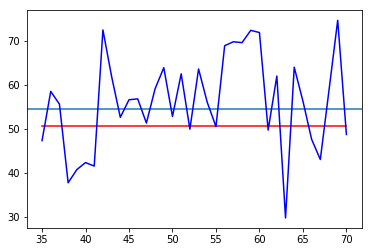

In [12]:
score = model.evaluate(X_test, y_test, batch_size=20)

print(model.metrics_names)  
print(score)    

y_pred = model.predict(X_test)
plt.plot(list(range(train_n,len(y))),y_pred,'r')
plt.axhline(y = np.average(y))
plt.plot(list(range(train_n,len(y))),y[train_n:],'b')
plt.show()